In [1]:
# !pip install dask
# !pip install s3fs
# !pip install boto3
# !pip install boto
# !pip install rich
import boto3
import folium
import json
import itertools
import circlify
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from boto3.session import Session
from collections import Counter, ChainMap
from datetime import datetime
from rich.console import Console
from rich.table import Table

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [291]:
# function to print table in nice way
def pretty_table(table_to_print, title=''):
    table_to_print = table_to_print.rename_axis(None, axis=0)
    console = Console()
    table = Table(title)
    table.add_row(table_to_print.to_string(float_format=lambda _: '{:.4f}'.format(_)))
    console.print(table)

In [4]:
# open file with credentials
path_to_file = r'C:\Users\mateu\Desktop\PROJEKT\credentials.txt'
credentials = open(path_to_file, 'r').read()

# assign access and secret keys
ACCESS_KEY = credentials.split('\n')[0]
SECRET_KEY = credentials.split('\n')[1]

# create class to load data files into one df
class LoadingData:

    def __init__(self, bucket, access_key, secret_key, path_to_files):
        self.bucket = bucket
        self.path_to_files = path_to_files
        self.s3 = self.load_s3_resource(access_key, secret_key)
        self.mappings = self.create_lists()[1]
        self.csv_files = self.create_lists()[0]
        
    def load_s3_resource(self, access_key, secret_key):
        s3 = boto3.resource(service_name='s3',
                            region_name='eu-central-1',
                            aws_access_key_id= access_key,
                            aws_secret_access_key= secret_key
                            )
        return s3
    
    def create_lists(self):
        list_of_files_in_S3 = []
        for obj in self.s3.Bucket(self.bucket).objects.all():
            list_of_files_in_S3.append(obj.key) 

        files = {item[:2]: item for item in list_of_files_in_S3 if item.endswith('.csv')}
        mappings = {item[:2]: item for item in list_of_files_in_S3 if item.endswith('.json')}
        
        return files, mappings

    def download_files(self):
        # create session while passing access key and secret key as parameter
        session = Session(aws_access_key_id=ACCESS_KEY,
                          aws_secret_access_key=SECRET_KEY)
        
        for region, file_name in self.csv_files.items():
            # session is authenticated and can access the resource in question 
            session.resource('s3').Bucket(self.bucket).download_file(file_name, self.path_to_files+file_name )
            
        for region, file_name in self.mappings.items():
            # session is authenticated and can access the resource in question 
            session.resource('s3').Bucket(self.bucket).download_file(file_name, self.path_to_files+file_name )
         
        return self.mappings, self.csv_files
    
if __name__ == "__main__":
    pass

In [5]:
# function to read and extract mappings from json files
def open_json(mapping_data):
    # extract mappings
    mapping = {mapping_data['items'][id_num]['id']: mapping_data['items'][id_num]['snippet']['title'] for id_num in range(0,len(mapping_data['items']))}

    # convert string (number of category) to int
    mapping = {int(k):v for k, v in mapping.items()}
    
    return mapping

# Load data (from AWS S3 bucket) and credentials 

In [6]:
# run class to download data
path_to_files = 'D:/video_data/'
set_up = LoadingData('videostrendingdata', ACCESS_KEY, SECRET_KEY, path_to_files)
mappings, files = set_up.download_files()

In [7]:
# read csv files
data_csv = {}

for region,file_name in files.items():
    data_csv['df_'+region] = pd.read_csv(path_to_files+file_name, encoding='latin-1')
    
# Add region column to each df
for region, dataframe in data_csv.items():
    dataframe['region'] = region[-2:] 
    
# union dfs
df = pd.concat(data_csv.values())

In [8]:
# create one mapping file from jsons
combined_json = []

for region, file in mappings.items():
    with open(path_to_files+file) as json_file:
        mapping_data = json.load(json_file)
        combined_json.append(open_json(mapping_data))

mappings_combined = ChainMap(*combined_json)

# Data transformation and analysis

In [141]:
# Count number of trending videos for each country
country_mapping = {
    'US':'United States of America',
    'CA': 'Canada',
    'DE': 'Germany',
    'RU': 'Russia',
    'FR': 'France',
    'MX': 'Mexico',
    'GB': 'United Kingdom',
    'IN': 'India ',
    'KR': 'South Korea',
    'JP': 'Japan'
}

temp_df = df.groupby(['region'], as_index=False)['region'].size()

temp_df['region'] = temp_df['region'].map(country_mapping)

temp_df = temp_df.rename(columns={'size':'count'})

In [143]:
#Setting up the world countries data URL
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json' 

# Make an empty map
m = folium.Map(location=[20,0], tiles='https://api.mapbox.com/v4/mapbox.streets/{z}/{x}/{y}.png?access_token=mytoken',
               attr='Mapbox attribution', zoom_start=1.7)

folium.Choropleth(
    geo_data=country_shapes,
    name='Trending videos',
    data=temp_df,
    columns=['region', 'count'],
    key_on='feature.properties.name',
    # threshold_scale=custom_scale,
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=.9,
    nan_fill_color='white',
    highlight=True,
    legend_name="Country and number of trending videos",
    smooth_factor=0,
    line_color = "#F0FFFF",
    show=True,
    overlay=True,
).add_to(m)

pretty_table(temp_df.set_index('region'), 'Country and number of trending videos')

m

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Country and number of trending videos ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                           count       │
│ Canada                    40881       │
│ Germany                   40840       │
│ France                    40724       │
│ United Kingdom            38916       │
│ India                     37352       │
│ Japan                     20523       │
│ South Korea               34567       │
│ Mexico                    40451       │
│ Russia                    40739       │
│ United States of America  40949       │
└───────────────────────────────────────┘

In [9]:
# drop some columns
df.drop(['video_id', 'title', 'thumbnail_link', 'description'], axis=1, inplace=True)

# convert booleans into int
df[['comments_disabled','ratings_disabled','video_error_or_removed']] = df[['comments_disabled','ratings_disabled','video_error_or_removed']].astype(int)

In [10]:
# map category
df['category'] = df['category_id'].map(mappings_combined)

In [11]:
# create list of values and names [category_id] sorted (ascending) and create list of combined values
list_of_values = df['category'].value_counts(sort=True, ascending=True).tolist()
list_of_indexes = df['category'].value_counts(sort=True, ascending=True).index.tolist()

combined = [list_of_indexes[i] + ', ' + str(list_of_values[i]) for i in range(0, len(list_of_indexes))]

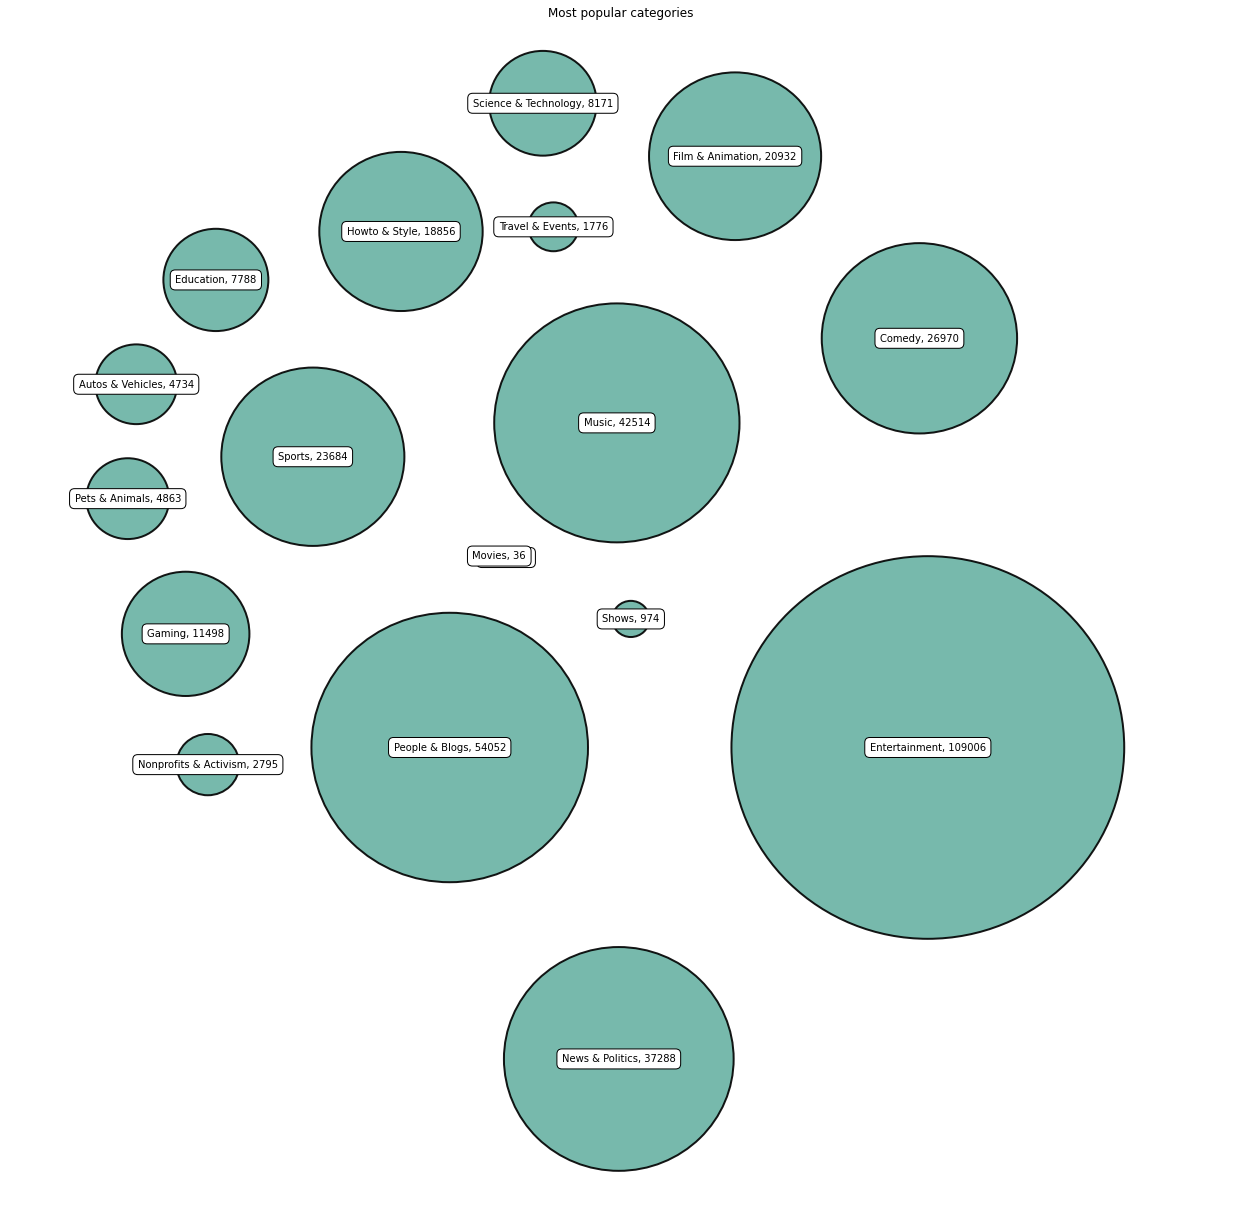

In [12]:
# compute circle positions:
circles = circlify.circlify(
    list_of_values, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(22,22))

# Title
ax.set_title('Most popular categories')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = combined

# print circles
for circle, label in zip(circles, labels):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r*0.7, alpha=0.9, linewidth=2, facecolor="#69b2a3", edgecolor="black"))
    plt.annotate(label, (x,y ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))


### Distribution of categories
The chart above is presenting how many times videos were tied to specific category. As we can see the most common category is **Entertainment**.

In [13]:
# format tags - remove quotas and convert it into lists 
df['tags_list'] = df['tags'].str.replace('"','').str.lower().str.split('|')

# create big list with all tags lists -> list = [list1,list2,list3,...]
tags = df['tags_list'].tolist()

# convert it to flat list: [list1,list2,list3,...] -> [list1_elements, list2_elements, ..] i.e. [[1,2,3],[4,5]] -> [1,2,3,4,5]
tags = list(itertools.chain(*tags))

In [14]:
# get 20 tags that are the most common
top_20_tags = Counter(tags).most_common()[:20]

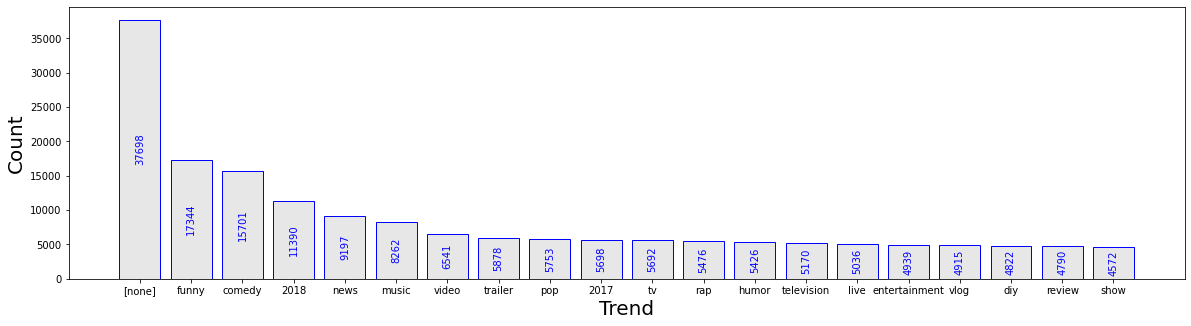

In [15]:
# create a dataset
bars = [tag[0] for tag in top_20_tags]
height = [tag[1] for tag in top_20_tags]
x_pos = np.arange(len(bars))

fig, ax = plt.subplots()    
# Create bars with blue edge color
plt.bar(x_pos, height, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')

# Add value to the bar
ax.bar_label(ax.containers[0], label_type='center', rotation=90, color='blue')

# Create names on the x-axis
plt.xticks(x_pos, bars)

ax.set_xlabel("Trend",fontsize=20)
ax.set_ylabel("Count",fontsize=20)

# Show chart
plt.gcf().set_size_inches(20, 5);

### Distirbution of tags
After separeting tags, we can conclude that most of videos are treated as funny/comedy (top 2 most common tags). Interesting thing is that almost 2400 videos are labeld with 0 tags.

In [16]:
df['likes/dislikes'] = df['likes']/df['dislikes']
temp_df = df[['category','likes/dislikes']]

C:\Users\mateu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\mateu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:4489: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
posx and posy should be finite values
posx and posy should be finite values


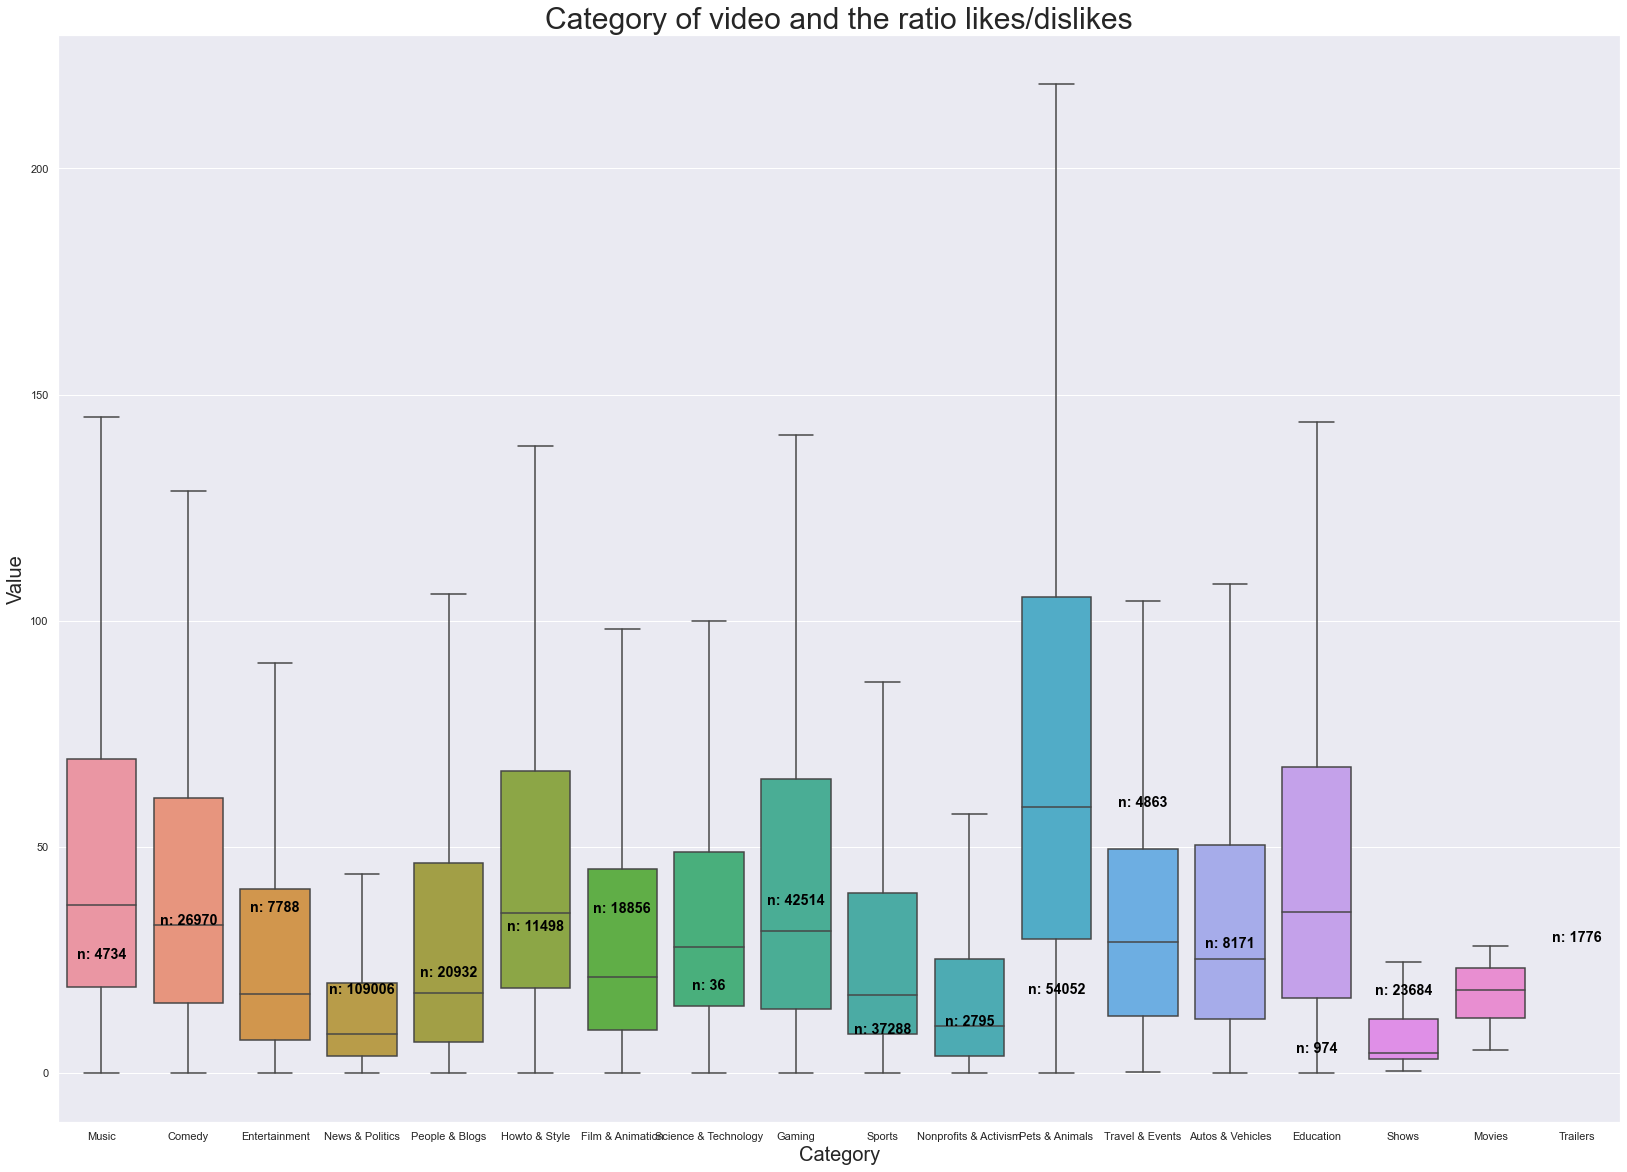

In [17]:
# create seaborn chart
sns.set(rc={'figure.figsize':(28,20)})

ax = sns.boxplot(x='category', y='likes/dislikes', data=temp_df, showfliers=False)

medians = df.groupby(['category'])['likes/dislikes'].median().values
nobs = df.groupby("category").size().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# Add it to the plot
pos = range(len(nobs))

for tick,label in zip(pos,ax.get_xticklabels()):
    plt.text(pos[tick], medians[tick], nobs[tick], horizontalalignment='center', size='large', color='black', weight='bold')

# add title
ax.axes.set_title("Category of video and the ratio likes/dislikes",fontsize=30)
ax.set_xlabel("Category",fontsize=20)
ax.set_ylabel("Value",fontsize=20);

### Distribution of ratio between likes and dislikes for each category
As we can observe the favorite category is Gaming and Howto & Style, the least liked category is Shows.

In [18]:
# change format of publish_time and trending_date
df['publish_time'] = pd.to_datetime(df['publish_time'].astype('datetime64[ns]').dt.strftime('%d/%m/%Y'), format="%d/%m/%Y")
df['trending_date'] = pd.to_datetime(pd.to_datetime(df['trending_date'], format="%y.%d.%m").dt.strftime('%d/%m/%Y'), format="%d/%m/%Y")

In [19]:
# create column with number of days that video needed to become trend
df['time_to_trend'] = (df['trending_date'] - df['publish_time']).dt.days

#create column with publish date in format MMYYYY
df['publish_month'] = pd.to_datetime(df['publish_time'], format='%YYYY-%m-%d').dt.month 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ How many days video needed to become popular over categories                            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                        1 day  2 day  3-5 days  6-10 days  11-30 days  more than 30 days │
│ Autos & Vehicles        3097    749       331        192          80                 42 │
│ Comedy                 11574   6291      5136       1658        1229                163 │
│ Education               3693   1361      1214        705         383                 98 │
│ Entertainment          51974  23284     16486       6038        5508                587 │
│ Film & Animation        9142   4002      3563       1593        1625                250 │
│ Gaming                  5035   2190      1554        878         822                 78 │
│ Howto & Style           9078   2776      2578       2007        1441                 95 │
│ Movies                    13      6        11          3           0                  0 │
│ Music                  11172   6985      8229       5385        8275               1399 │
│ News & Politics        19544   8661      5242       1231         628                 64 │
│ Nonprofits & Activism   1750    477       197         48          48                 10 │
│ People & Blogs         28746  10157      6537       2433        2049                389 │
│ Pets & Animals          2362    647       668        467         450                 50 │
│ Science & Technology    3383   1439      1470       1003         566                 74 │
│ Shows                    621    206        81         21          40                  0 │
│ Sports                 12940   3694      2346       1246         823                140 │
│ Trailers                   0      1         3          0           1                  0 │
│ Travel & Events          775    317       268        190         101                 21 │
└─────────────────────────────────────────────────────────────────────────────────────────┘

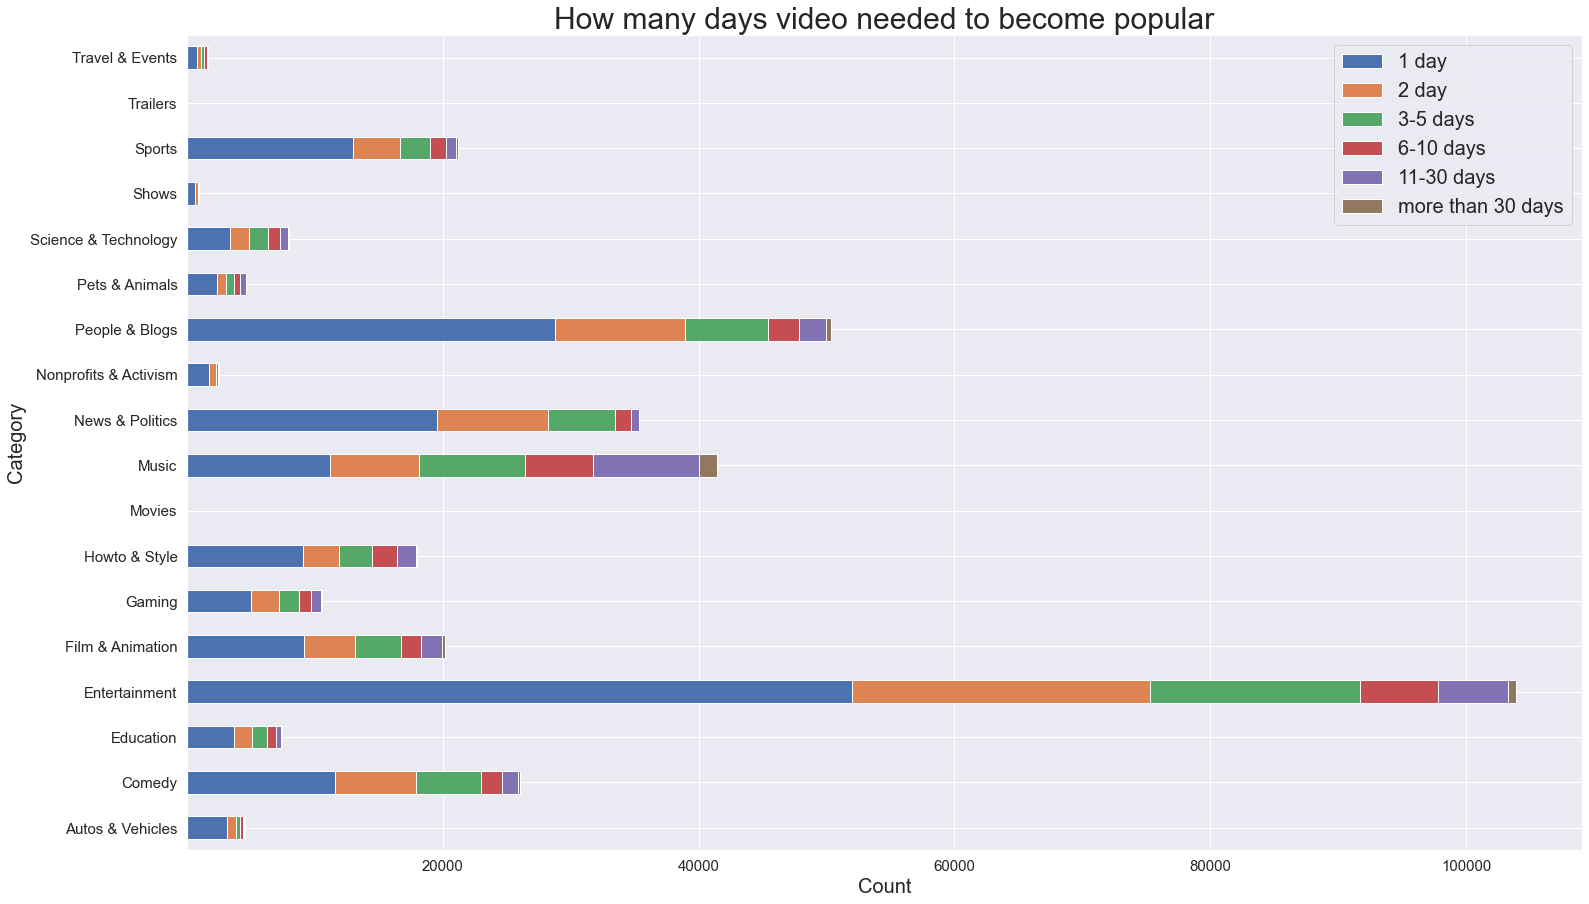

In [20]:
list_of_cols = ["1 day", "2 day", "3-5 days", "6-10 days", "11-30 days", "more than 30 days"] 

# create bins for column time_to_trend
bins = [0, 1, 2, 5, 10, 30, float("inf")]
df_time_to_trend = df[['category','time_to_trend']].groupby(['category', pd.cut(df.time_to_trend, bins)]).size().unstack()
df_time_to_trend.columns = df_time_to_trend.columns.astype(str)

# rename columns
for col in range(0,len(df_time_to_trend.columns)):
    df_time_to_trend.columns.values[col] = list_of_cols[col]

# remove index names
df_time_to_trend = df_time_to_trend.rename_axis(None, axis=1)
df_time_to_trend = df_time_to_trend.rename_axis(None, axis=0)

# create chart with stacked bars
ax = df_time_to_trend.plot.barh(stacked=True, figsize=(25, 15))

# format legend
ax.legend(list_of_cols, fontsize=20)
# format size of ticks
ax.tick_params(axis='both', labelsize=15)

# change title and labels
ax.axes.set_title('How many days video needed to become popular',fontsize=30)
ax.set_xlabel("Count",fontsize=20)
ax.set_ylabel("Category",fontsize=20);

# print table with data as well
pretty_table(df_time_to_trend, 'How many days video needed to become popular over categories')

In [26]:
# create df for top 20 channels - count of trending videos
df['channel_title'].value_counts()

# create list of values and names [category_id] sorted (ascending) and create list of combined values
list_of_values_channel = df['channel_title'].value_counts(sort=True, ascending=False).tolist()
list_of_indexes_channel = df['channel_title'].value_counts(sort=True, ascending=False).index.tolist()

combined_channels = [list_of_indexes_channel[i] + ': ' + str(list_of_values_channel[i]) for i in range(0, len(list_of_indexes_channel))]

temp_df = pd.DataFrame(list(zip(list_of_indexes_channel, list_of_values_channel, combined_channels)), columns=['Channel', 'Count', 'Combined']).iloc[:21]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Top 20 channels                               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                                         Count │
│ The Late Show with Stephen Colbert        984 │
│ WWE                                       804 │
│ Late Night with Seth Meyers               773 │
│ VikatanTV                                 763 │
│ TheEllenShow                              743 │
│ Jimmy Kimmel Live                         707 │
│ The Tonight Show Starring Jimmy Fallon    705 │
│ PewDiePie                                 652 │
│ RadaanMedia                               651 │
│ The Late Late Show with James Corden      583 │
│ CNN                                       579 │
│ Netflix                                   566 │
│ FBE                                       555 │
│ MLG Highlights                            549 │
│ SET India                                 528 │
│ Screen Junkies                            494 │
│ ESPN                                      486 │
│ Marvel Entertainment                      482 │
│ BuzzFeedVideo                             481 │
│ Warner Bros. Pictures                     470 │
│ Ãukur                                    466  │
└───────────────────────────────────────────────┘

C:\Users\mateu\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 135 (\x87) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


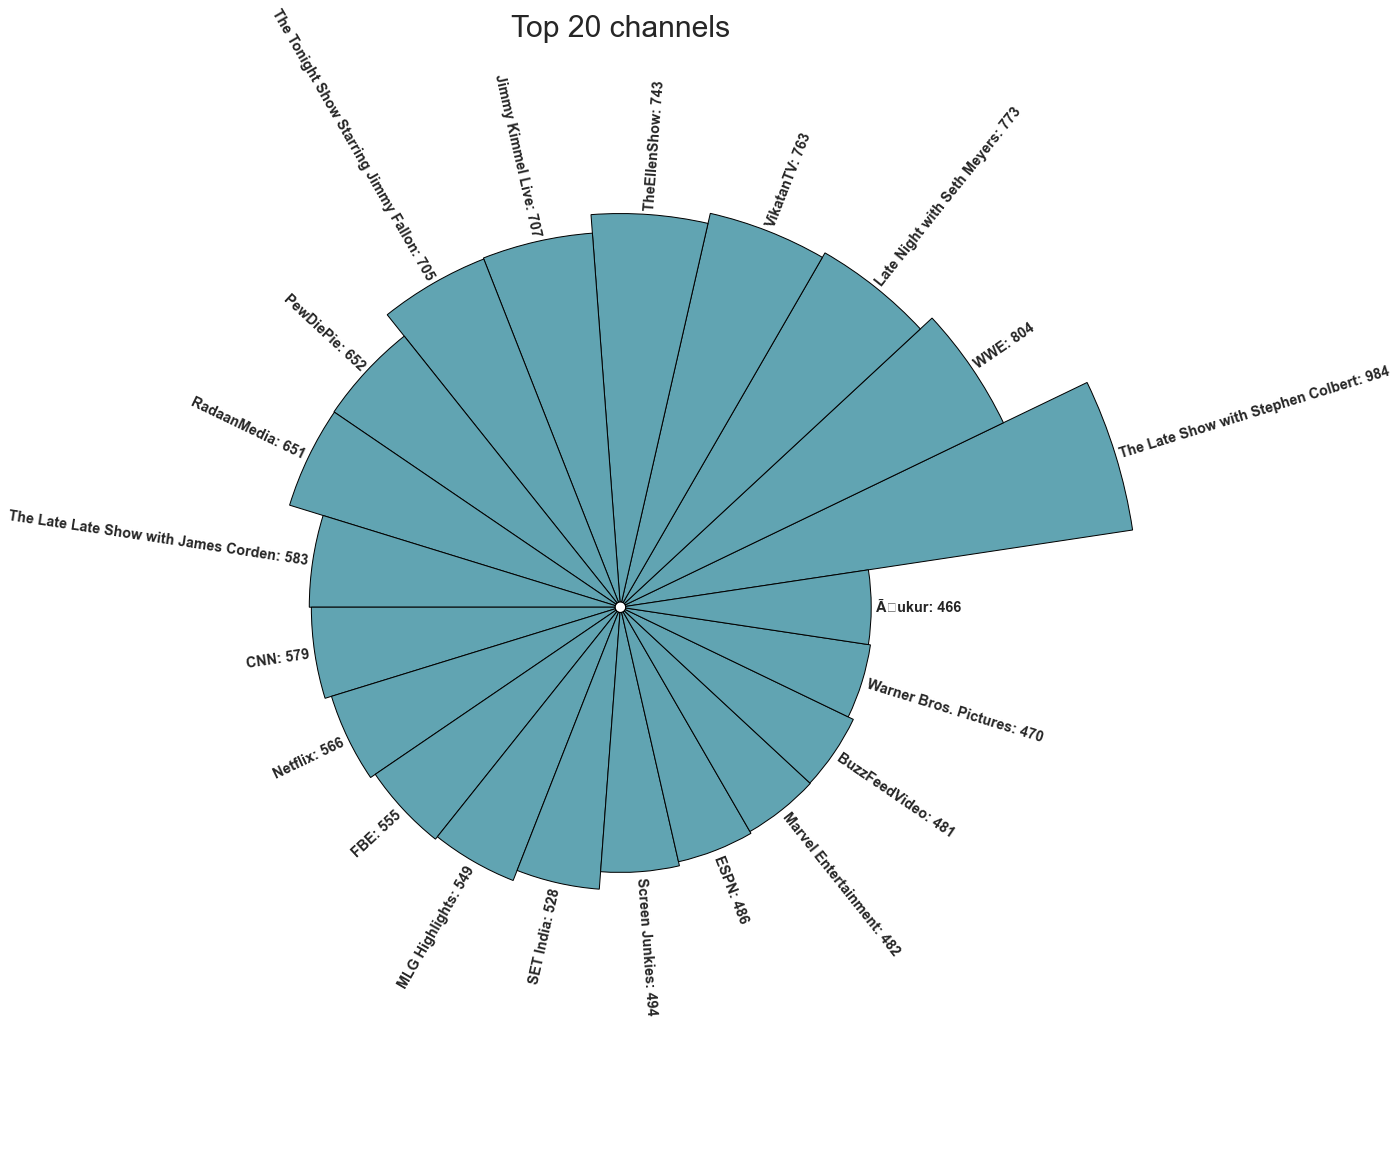

In [27]:
# set figure size
plt.figure(figsize=(25,20))

# plot polar axis
ax = plt.subplot(111,polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = 100
lowerLimit = 10

# Compute max and min in the dataset
max = temp_df['Count'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * temp_df.Count + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(temp_df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(temp_df.index)+1))
angles = [element * width for element in indexes]

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    color="#61a4b2",
    linewidth=1, 
    edgecolor="black")

# little space between the bar and the label
labelPadding = 10

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, temp_df["Combined"]):

    # Labels are rotated. Rotation must be specified in degrees
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding,
        s=label, 
        ha=alignment,
        fontsize = 'large',
        fontweight = 'bold',
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")
    
ax.axes.set_title('Top 20 channels',fontsize=30);

# print table; set index col and remove header
temp_df = temp_df[['Channel','Count']].set_index('Channel')
temp_df = temp_df.rename_axis(None, axis=0)
pretty_table(temp_df, 'Top 20 channels')

In [286]:
# prepare data for visualization: country X category X count
country_df = df[['region','category']].groupby(['region','category'], as_index=False).size()

country_df['region'] = country_df['region'].map(country_mapping)

In [287]:
# pivot table and remove indexes
country_df_pivoted = pd.pivot_table(country_df, values='size', index=['category'], columns=['region'], aggfunc=np.sum)

country_df_pivoted = country_df_pivoted.reset_index().rename_axis(None, axis=1).rename(columns={'category':''}).set_index('')

,Canada,France,Germany,India,Japan,Mexico,Russia,South Korea,United Kingdom,United States of America
,,,,,,,,,,
Autos & Vehicles,353.0,673.0,873.0,72.0,280.0,252.0,1583.0,120.0,144.0,384.0
Comedy,3773.0,4343.0,2534.0,3429.0,743.0,1742.0,3065.0,2056.0,1828.0,3457.0
Education,991.0,769.0,844.0,1227.0,112.0,532.0,714.0,486.0,457.0,1656.0
Entertainment,13451.0,9819.0,15292.0,16712.0,6259.0,13487.0,5943.0,8955.0,9124.0,9964.0
Film & Animation,2060.0,2157.0,2376.0,1658.0,1220.0,1298.0,3041.0,2200.0,2577.0,2345.0
Gaming,1344.0,1459.0,1565.0,66.0,1030.0,994.0,1043.0,1392.0,1788.0,817.0
Howto & Style,2007.0,2361.0,1745.0,845.0,799.0,2467.0,2000.0,558.0,1928.0,4146.0
Movies,6.0,11.0,2.0,16.0,NaN,NaN,1.0,NaN,NaN,NaN
Music,3731.0,3946.0,2372.0,3858.0,1290.0,3371.0,1895.0,1825.0,13754.0,6472.0


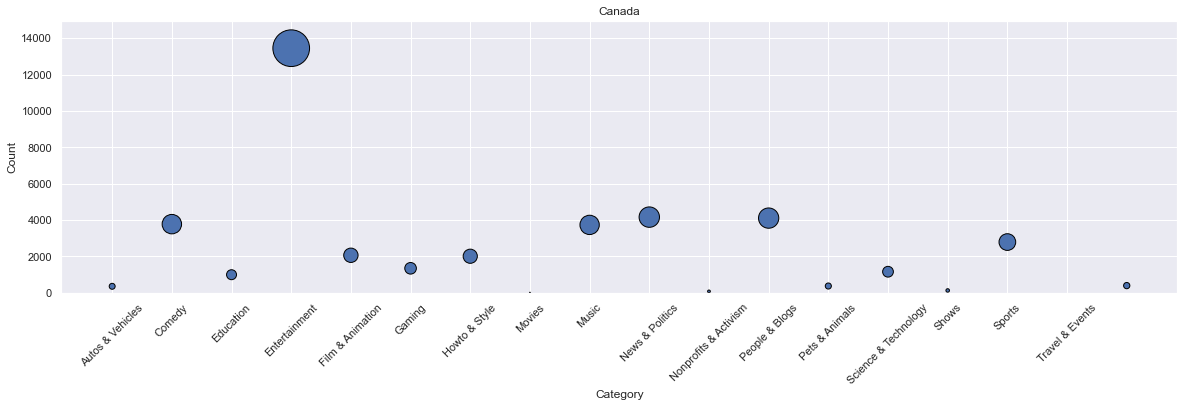

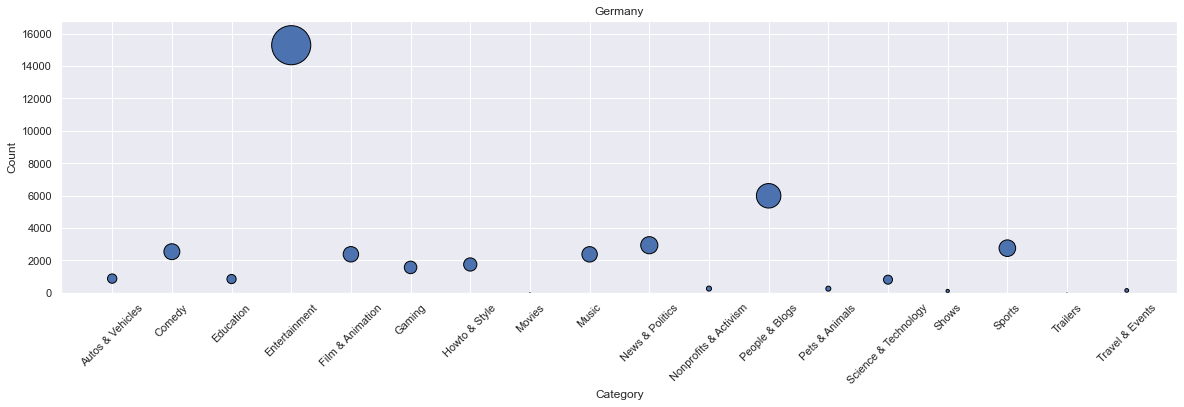

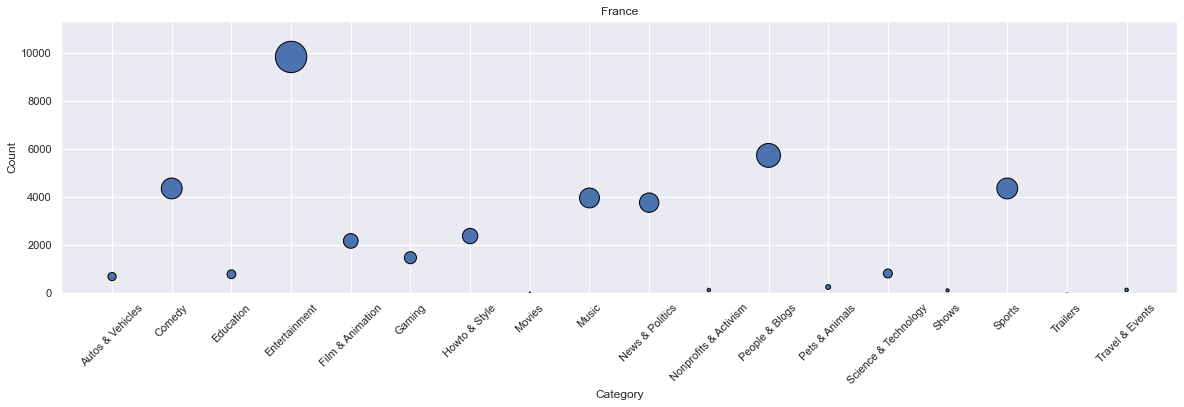

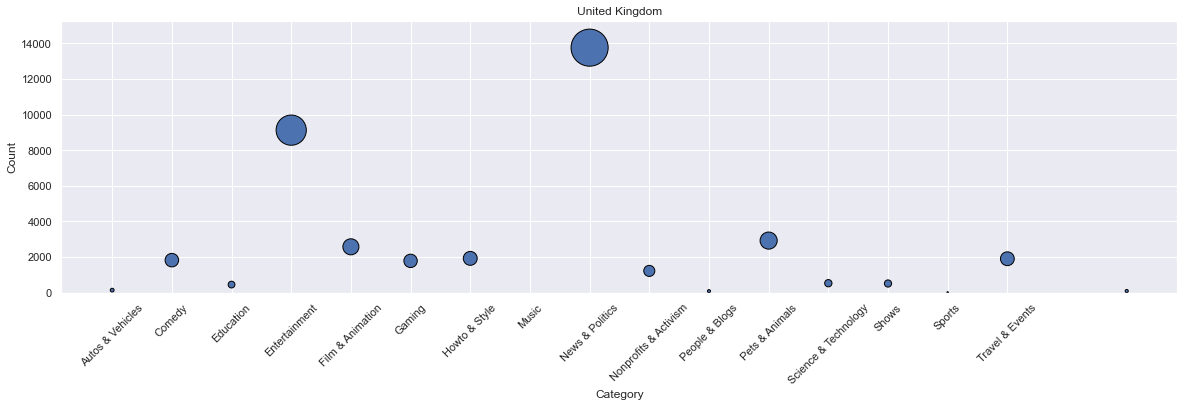

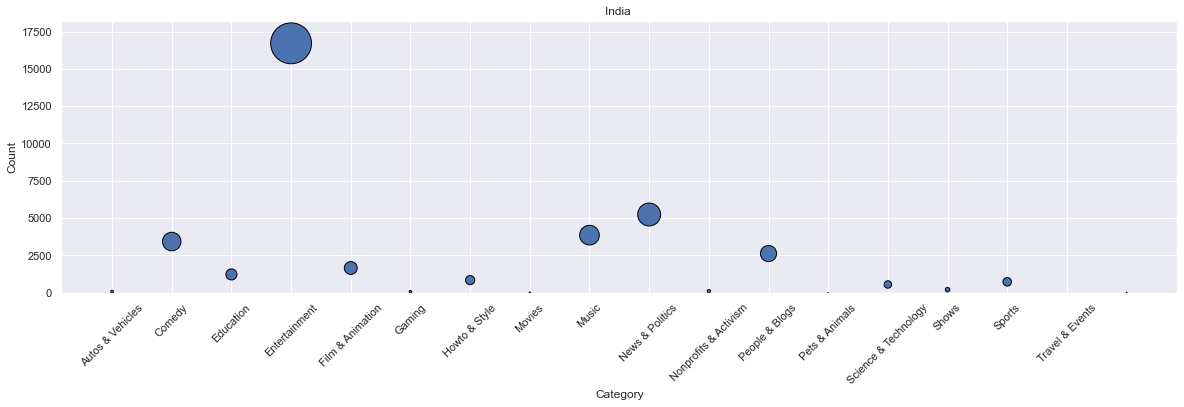

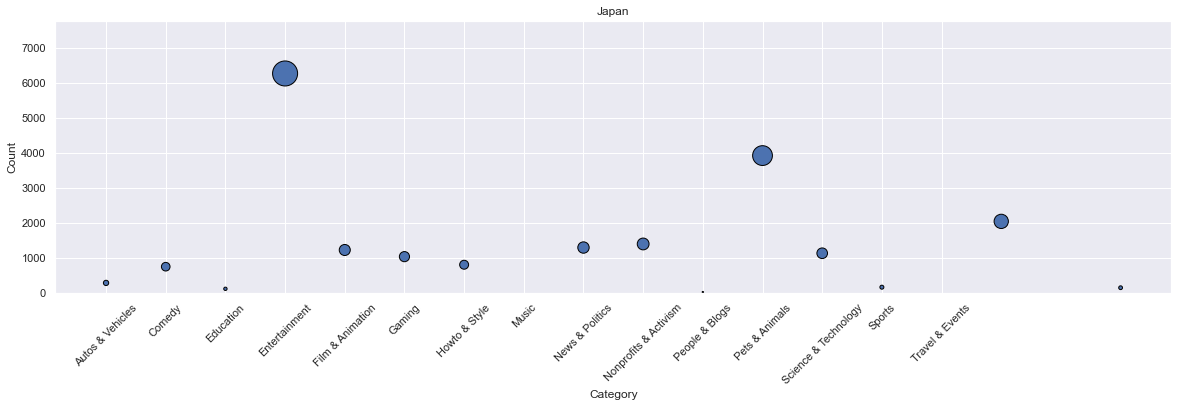

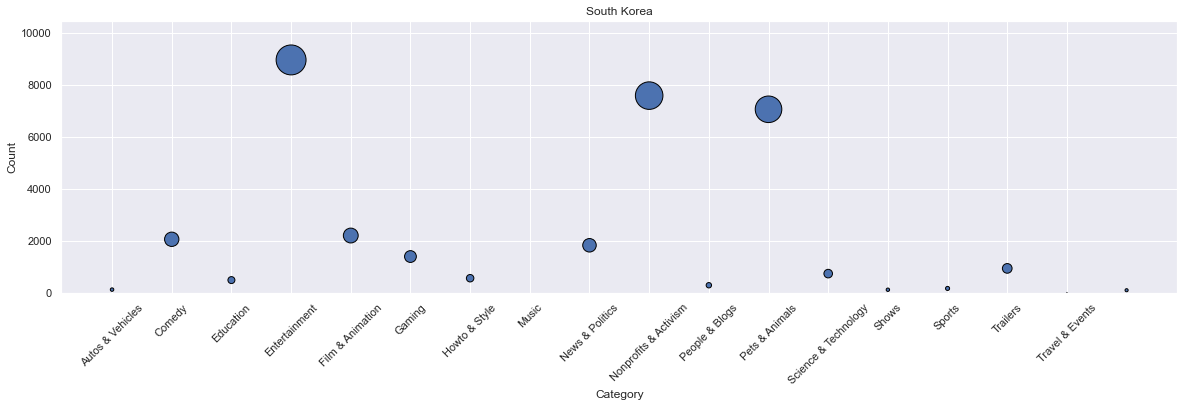

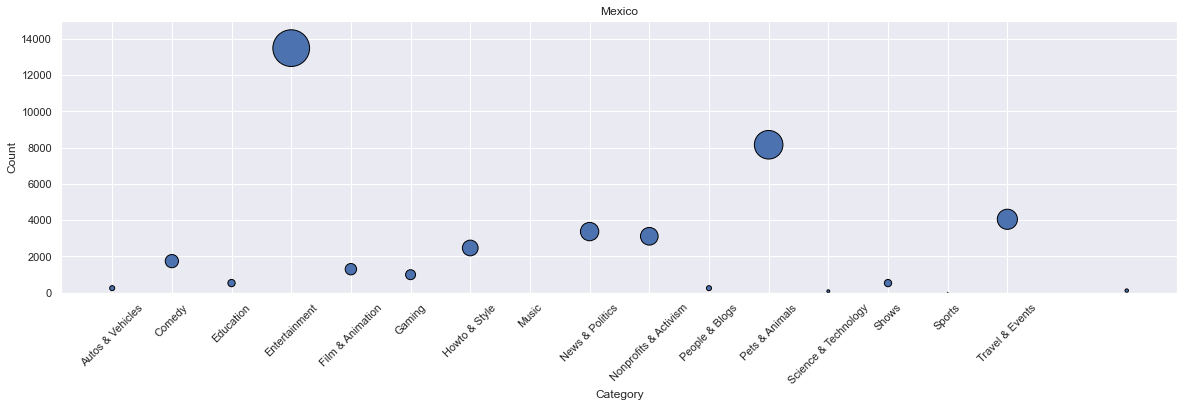

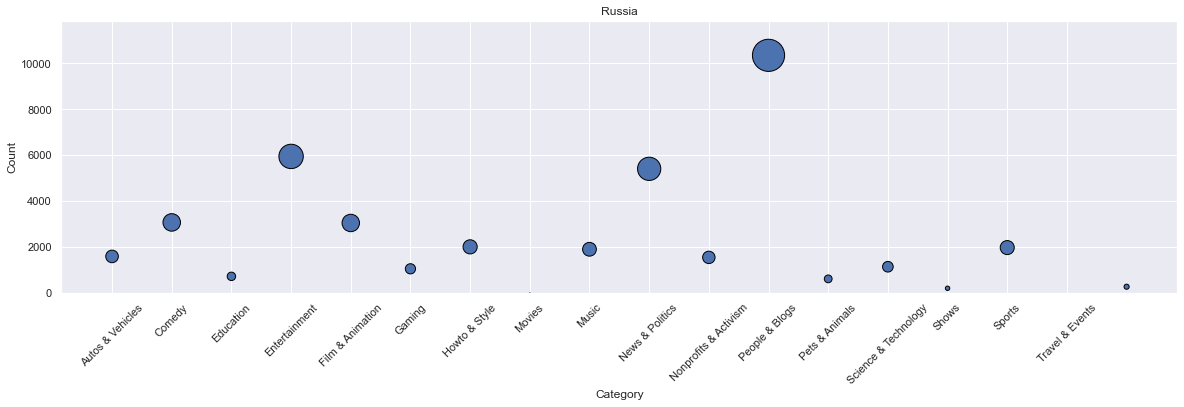

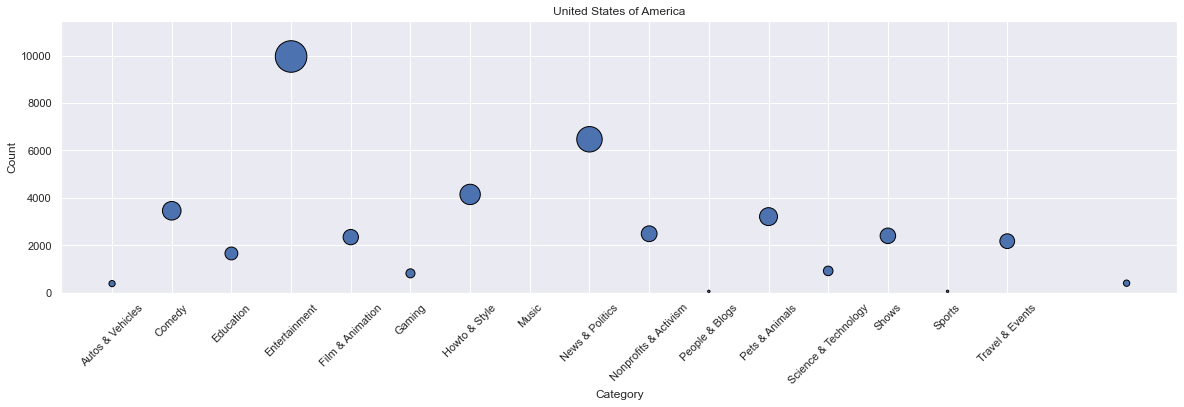

In [293]:
# transform categorical column in a numerical value
country_df['region']=pd.Categorical(country_df['region'])
country_df['category']=pd.Categorical(country_df['category'])

for country in country_df['region'].unique():
    
    temp_df = country_df[country_df['region'] == country]

    # Set the figure size
    plt.figure(figsize=(20, 5))

    # Scatterplot
    plt.scatter(
        x = temp_df['category'].cat.codes, 
        y = temp_df['size'],
        marker="o", 
        s = temp_df['size']/10,
        cmap="Accent", 
        alpha=1, 
        edgecolors="black", 
        linewidth=1);

    # Add titles (main and on axis)
    x = temp_df['category'].tolist()
    default_x_ticks = range(len(x))
    plt.xticks(default_x_ticks, x)
    plt.xticks(rotation = 45)
    plt.ylim(0,temp_df['size'].max()+1500)

    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.title(country);

country_df_pivoted

### Preparation to run the model

In [23]:
numerical_cols = list(df.select_dtypes([np.number]).columns)
categorical_cols = list(set(df.columns) - set(numerical_cols))